In [2]:
from datetime import datetime, timedelta
import yfinance as yf

# nifty50 = yf.Ticker("^NSEI")
# sbilife = yf.Ticker("AAPL")
sbilife = yf.Ticker("SBILIFE.NS")
# pprint.pprint(sbilife.history_metadata)
# sbilife.history(interval="1d", start="2021-01-01", end="2021-01-10")
sbilife.history(interval="1d", start="2021-01-01")
now = datetime.now()
start_date = now - timedelta(days=729)
end_date = now
data_weekly = sbilife.history(
    interval="30m",
    period="1mo",
    actions=True,
    prepost=True,
    auto_adjust=True,
    repair=True,
)

/home/sps/ProgramFiles/anaconda/anaconda3/envs/ibkr/lib/python3.9/site-packages/yfinance/scrapers/history.py:239: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  quotes2 = quotes.resample('30T')


In [7]:
data_weekly

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Repaired?
Datetime,,,,,,,,
2024-09-12 09:00:00+05:30,1856.949951,1870.400024,1856.949951,1863.500000,31170,0.0,0.0,False
2024-09-12 09:30:00+05:30,1864.449951,1869.599976,1860.000000,1860.000000,26361,0.0,0.0,False
2024-09-12 10:00:00+05:30,1860.800049,1867.099976,1853.000000,1854.300049,21876,0.0,0.0,False
2024-09-12 10:30:00+05:30,1854.050049,1863.099976,1851.000000,1856.699951,32048,0.0,0.0,False
2024-09-12 11:00:00+05:30,1857.599976,1859.500000,1849.599976,1850.650024,44534,0.0,0.0,False
...,...,...,...,...,...,...,...,...
2024-10-11 13:00:00+05:30,1735.150024,1746.650024,1733.550049,1745.650024,48762,0.0,0.0,False
2024-10-11 13:30:00+05:30,1744.599976,1746.699951,1737.250000,1742.449951,42153,0.0,0.0,False
2024-10-11 14:00:00+05:30,1742.449951,1743.949951,1736.250000,1738.050049,17664,0.0,0.0,False


In [3]:
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
import matplotlib.pyplot as plt
import mplfinance as mpf


class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def request(self, method, url, *args, **kwargs):
        # Get the cached response, if available
        cached_response = self.cache.get_response(url)
        headers = kwargs.get("headers", {})
        print(headers)

        if cached_response:
            # etag = cached_response[0].headers.get("ETag")
            headers["If-Modified-Since"] = cached_response.headers["date"]

            # print(etag)
            print(headers["If-Modified-Since"])

            # if etag:
            # headers["If-None-Match"] = etag
            # kwargs["headers"] = headers

        response = super().request(method, url, *args, **kwargs)

        if response.status_code == 304:
            # Not modified, use the cached response
            response = cached_response[0]
            print("Not modified")
        else:
            # Update the cache with the new response
            self.cache.save_response(response, cache_key=url)
            print("Modified")

        return response


session = CachedLimiterSession(
    limiter=Limiter(
        RequestRate(2, Duration.SECOND * 5)
    ),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache.db"),
    # expire_after=timedelta(days=1),
)

session.headers["User-agent"] = "yfinaince-cache/1.0"
company = yf.Ticker("SBILIFE.NS", session=session)

In [ ]:
now = datetime.now()
start_date = now - timedelta(days=59)
end_date = now

data_30m60day = company.history(
    interval="30m",
    start=start_date,
    end=end_date,
    actions=True,
    prepost=True,
    auto_adjust=True,
    repair=True,
)

data_30m60day["Ticker"] = "SBILIFE.NS"
# Calculate the 200 period  exponential moving average
ema_200_intraday = data_30m60day["Close"].ewm(span=200, adjust=False).mean()
data_30m60day["ema_200"] = ema_200_intraday
data_30m60day["Trend"] = data_30m60day["Close"] > data_30m60day["ema_200"]
data_30m60day["Bullish"] = data_30m60day["Close"] > data_30m60day["ema_200"]
data_30m60day["Bearish"] = data_30m60day["Close"] < data_30m60day["ema_200"]


# Check if the trend is bullish for intraday
is_bullish = (
    data_30m60day["Bullish"].tail(10).sum() > 10
    and data_30m60day["Bullish"].tail(100).sum() > 70
)


data_for_plot_intraday = data_30m60day[
    ["Open", "High", "Low", "Close", "Volume", "ema_200"]
]
ema_plot_intraday = mpf.make_addplot(data_for_plot_intraday["ema_200"], color="orange")
mpf.plot(
    data_for_plot_intraday,
    type="candle",
    style="charles",
    volume=True,
    addplot=ema_plot_intraday,
)

In [ ]:
session = CachedLimiterSession(
    limiter=Limiter(
        RequestRate(2, Duration.SECOND * 5)
    ),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache.db"),
    expire_after=timedelta(days=1),
)

session.headers["User-agent"] = "yfinaince-cache/1.0"

end_date = datetime.now()
start_date = end_date - timedelta(days=59)

company = yf.Ticker("BAJAJ-AUTO.NS", session=session)
d = company.history(
    interval="30m",
    start=start_date,
    end=end_date,
    actions=True,
    prepost=True,
    auto_adjust=True,
    repair=True,
)

In [10]:
d.sort_index(ascending=False)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Repaired?
Datetime,,,,,,,,
2024-10-11 15:00:00+05:30,11857.599609,11909.799805,11850.000000,11876.950195,26742,0.0,0.0,False
2024-10-11 14:30:00+05:30,11855.150391,11870.000000,11848.500000,11859.799805,10788,0.0,0.0,False
2024-10-11 14:00:00+05:30,11863.000000,11863.349609,11830.599609,11855.000000,8668,0.0,0.0,False
2024-10-11 13:30:00+05:30,11851.049805,11890.000000,11842.500000,11863.000000,10047,0.0,0.0,False
2024-10-11 13:00:00+05:30,11862.000000,11875.500000,11850.000000,11854.900391,8466,0.0,0.0,False
...,...,...,...,...,...,...,...,...
2024-08-16 09:30:00+05:30,9817.650391,9858.000000,9759.000000,9798.400391,39398,0.0,0.0,False
2024-08-16 09:00:00+05:30,9786.799805,9830.000000,9746.000000,9817.650391,22374,0.0,0.0,False
2024-08-14 15:00:00+05:30,9742.000000,9774.250000,9718.400391,9724.000000,42592,0.0,0.0,False


{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36', 'If-Modified-Since': 'Sat, 12 Oct 2024 20:24:26 GMT'}
Sun, 13 Oct 2024 06:02:33 GMT
Modified


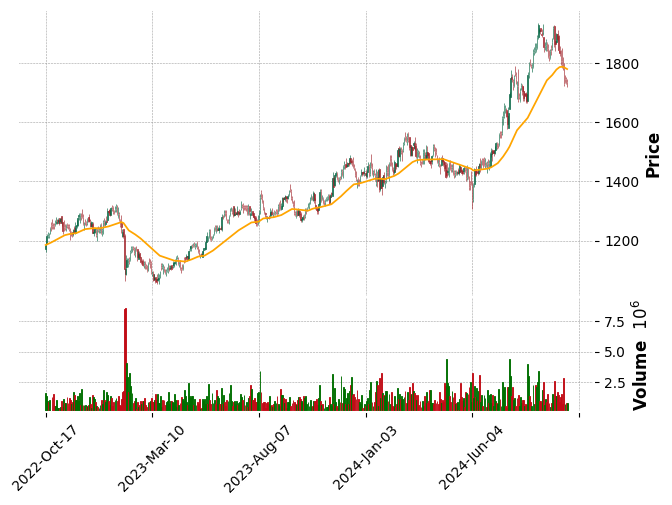

In [25]:
start_date = now - timedelta(days=729)
data_1d730day = company.history(
    interval="1d",
    start=start_date,
    end=end_date,
    actions=True,
    prepost=True,
    auto_adjust=True,
    repair=True,
)

ema_50_swing = data_1d730day["Close"].ewm(span=50, adjust=False).mean()
data_1d730day["ema_50"] = ema_50_swing
data_1d730day["Trend"] = data_1d730day["Close"] > data_1d730day["ema_50"]
data_1d730day["Bullish"] = data_1d730day["Close"] > data_1d730day["ema_50"]
data_1d730day["Bearish"] = data_1d730day["Close"] < data_1d730day["ema_50"]


# Check if the trend is bullish for swing
is_bullish_swing = (
    data_1d730day["Bullish"].tail(10).sum() > 10
    and data_1d730day["Bullish"].tail(100).sum() > 70
)

data_for_plot_swing = data_1d730day[
    ["Open", "High", "Low", "Close", "Volume", "ema_50"]
]
ema_plot_swing = mpf.make_addplot(data_for_plot_swing["ema_50"], color="orange")
mpf.plot(
    data_for_plot_swing,
    type="candle",
    style="charles",
    volume=True,
    addplot=ema_plot_swing,
)

In [26]:
data_1d730day

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Repaired?,ema_50,Trend,Bullish,Bearish
Date,,,,,,,,,,,,
2022-10-17 00:00:00+05:30,1173.132861,1193.697565,1162.775806,1184.884155,1615547,0.0,0.0,False,1184.884155,False,False,False
2022-10-18 00:00:00+05:30,1190.809526,1220.934542,1188.220292,1214.013306,1367703,0.0,0.0,False,1186.026475,True,True,False
2022-10-19 00:00:00+05:30,1214.959388,1228.702420,1208.336839,1222.030029,947326,0.0,0.0,False,1187.438379,True,True,False
2022-10-20 00:00:00+05:30,1214.959332,1224.918015,1208.984122,1217.897095,878595,0.0,0.0,False,1188.632838,True,True,False
2022-10-21 00:00:00+05:30,1223.374372,1245.084350,1221.930412,1241.200439,1020728,0.0,0.0,False,1190.694313,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-07 00:00:00+05:30,1800.000000,1819.849976,1776.000000,1787.949951,692912,0.0,0.0,False,1787.929940,True,True,False
2024-10-08 00:00:00+05:30,1785.000000,1799.050049,1723.550049,1728.050049,2888148,0.0,0.0,False,1785.581709,False,False,True
2024-10-09 00:00:00+05:30,1748.050049,1759.000000,1733.050049,1737.400024,704112,0.0,0.0,False,1783.692231,False,False,True


{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
Sat, 12 Oct 2024 20:24:26 GMT
Modified


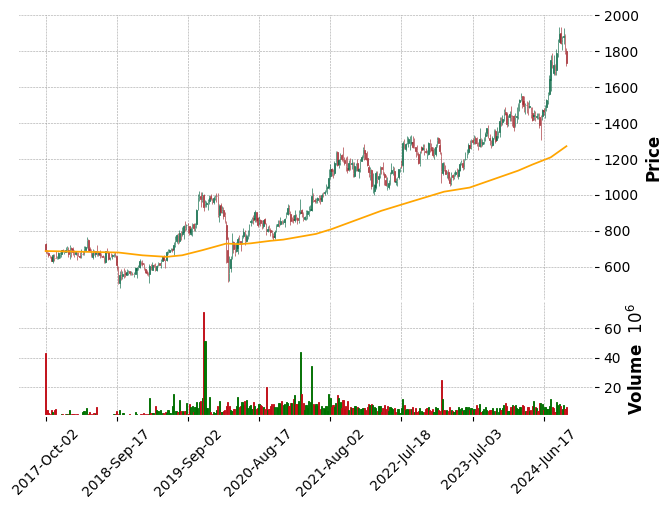

In [4]:
start_date = now - timedelta(days=365 * 5)
data_1wk5yr = company.history(
    interval="1wk",
    period="max",
    actions=True,
    prepost=True,
    auto_adjust=True,
    repair=True,
)

ema_200_positional = data_1wk5yr["Close"].ewm(span=200, adjust=False).mean()
data_1wk5yr["ema_200"] = ema_200_positional
data_1wk5yr["Trend"] = data_1wk5yr["Close"] > data_1wk5yr["ema_200"]
data_1wk5yr["Bullish"] = data_1wk5yr["Close"] > data_1wk5yr["ema_200"]
data_1wk5yr["Bearish"] = data_1wk5yr["Close"] < data_1wk5yr["ema_200"]


# Check if the trend is bullish for positional
is_bullish_positional = (
    data_1wk5yr["Bullish"].tail(10).sum() > 10
    and data_1wk5yr["Bullish"].tail(100).sum() > 70
)

data_for_plot_positional = data_1wk5yr[
    ["Open", "High", "Low", "Close", "Volume", "ema_200"]
]
ema_plot_positional = mpf.make_addplot(
    data_for_plot_positional["ema_200"], color="orange"
)
mpf.plot(
    data_for_plot_positional,
    type="candle",
    style="charles",
    volume=True,
    addplot=ema_plot_positional,
)

In [5]:
data_1wk5yr

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Repaired?,ema_200,Trend,Bullish,Bearish
Date,,,,,,,,,,,,
2017-10-02 00:00:00+05:30,723.989312,728.914409,675.821835,686.312317,43078384,0.0,0.0,False,686.312317,False,False,False
2017-10-09 00:00:00+05:30,683.701908,692.468604,669.813159,679.367859,4367708,0.0,0.0,False,686.243218,False,False,True
2017-10-16 00:00:00+05:30,675.723246,679.121574,654.200598,664.986511,2145239,0.0,0.0,False,686.031708,False,False,True
2017-10-23 00:00:00+05:30,659.962985,663.706047,648.241231,652.279846,1865141,0.0,0.0,False,685.695869,False,False,True
2017-10-30 00:00:00+05:30,655.037852,658.977929,631.495866,632.628662,4672548,0.0,0.0,False,685.167837,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-09 00:00:00+05:30,1900.849976,1932.849976,1838.750000,1846.500000,7004555,0.0,0.0,False,1248.209738,True,True,False
2024-09-16 00:00:00+05:30,1851.000000,1885.000000,1808.449951,1870.250000,5228649,0.0,0.0,False,1254.399193,True,True,False
2024-09-23 00:00:00+05:30,1882.000000,1927.949951,1841.050049,1882.650024,8101044,0.0,0.0,False,1260.650445,True,True,False


In [ ]:
from datetime import timezone
import pytz

d1 = data_30m60day.index[0]
d2 = data_30m60day.index[0].tz_convert(timezone.utc)
d3 = data_30m60day.index[0].tz_convert(timezone.utc).to_pydatetime()

ist = pytz.timezone("Asia/Kolkata")

d4 = d2.tz_convert(ist).to_pydatetime()

d5 = d1.to_pydatetime()

d1, d2, d3, d4, d5

In [ ]:
import requests
from bs4 import BeautifulSoup


baseurl = "https://www.nseindia.com/"
url = f"https://www.nseindia.com/market-data/live-equity-market?symbol=NIFTY%2050"
headers = {
    "Host": "www.nseindia.com",
    "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linuxpprint x86_64; rv:126.0) Gecko/20100101 Firefox/126.0",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Referer": "https://www.nseindia.com/market-data/live-market-indices",
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",
    "Sec-Fetch-Dest": "document",
    "Sec-Fetch-Mode": "navigate",
    "Sec-Fetch-Site": "same-origin",
    "Sec-Fetch-User": "?1",
    "Priority": "u=1",
    "Pragma": "no-cache",
    "Cache-Control": "no-cache",
    "TE": "trailers",
}
session = requests.Session()
request = session.get(baseurl, headers=headers, timeout=5)
cookies = dict(request.cookies)
response = session.get(url, headers=headers, timeout=5, cookies=cookies)
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    # Find the table or the section containing the tickers
    table = soup.find("table")  # Adjust this to find the correct table
    print(table)
    tickers = []
    # for row in table.find_all("tr")[1:]:  # Skipping the header row
    # cols = row.find_all("td")
    # if len(cols) > 0:
    #     ticker = cols[0].text.strip()  # Adjust the index based on actual column
    #     tickers.append(ticker)
    # return tickers
    # print(cols)

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.support.wait import WebDriverWait

chrome_driver_executable_path = ChromeDriverManager().install()
service = Service(executable_path=chrome_driver_executable_path)

options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

driver = webdriver.Chrome(options=options, service=service)
tickers = []


driver.get("https://sg.finance.yahoo.com/quote/%5ENSEI/components/")
driver.set_window_size(1854, 1031)
WebDriverWait(driver, 10).until(
    expected_conditions.presence_of_element_located(
        (By.XPATH, '//div[@id="svelte"]//tr[@id="0"]//a')
    )
)
for i in range(1, 29):
    tickers.append(
        driver.find_element(By.XPATH, f'//div[@id="svelte"]//tr[@id="{i}"]//a').text
    )
print("{}".format(tickers))

driver.quit()

In [9]:
import pandas as pd

data_weekly = {
    "tickers": tickers,
    "provider": ["Yahoo"] * len(tickers),
    "index": ["^NSEI"] * len(tickers),
}
df = pd.DataFrame(data_weekly)
df.to_csv("Nifty50-Tickers.csv", index=False)

In [ ]:
# Breakout trading strategy

import yfinance as yf
import pandas as pd


def identify_levels(df, window=20):
    df["Rolling_Max"] = df["High"].rolling(window=window).max()
    df["Rolling_Min"] = df["Low"].rolling(window=window).min()
    return df


def detect_consolidation(df, threshold=0.02):
    df["Range"] = (df["Rolling_Max"] - df["Rolling_Min"]) / df["Rolling_Min"]
    df["Consolidating"] = df["Range"] < threshold
    return df


def detect_breakouts(df):
    df["Breakout_Up"] = (df["Close"] > df["Rolling_Max"].shift(1)) & df[
        "Consolidating"
    ].shift(1)
    df["Breakout_Down"] = (df["Close"] < df["Rolling_Min"].shift(1)) & df[
        "Consolidating"
    ].shift(1)
    return df


def execute_trades(df):
    df["Position"] = 0
    df.loc[df["Breakout_Up"], "Position"] = 1  # Buy signal
    df.loc[df["Breakout_Down"], "Position"] = -1  # Sell signal
    return df


# Fetch historical data
ticker = "AAPL"
data_weekly = yf.download(ticker, period="1y", interval="1d")

# Apply the breakout trading strategy
data_weekly = identify_levels(data_weekly)
data_weekly = detect_consolidation(data_weekly)
data_weekly = detect_breakouts(data_weekly)
data_weekly = execute_trades(data_weekly)

# Print the resulting DataFrame
print(
    data_weekly[
        [
            "Close",
            "Rolling_Max",
            "Rolling_Min",
            "Consolidating",
            "Breakout_Up",
            "Breakout_Down",
            "Position",
        ]
    ].tail()
)

In [61]:
from __future__ import absolute_import, division, print_function, unicode_literals

import datetime  # For datetime objects

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):

    # This is where we add the parameters we need for the strategy
    params = (
        ('maperiod', 5),
        ('printlog', False),
    )

    def log(self, txt, doprint=False):
        """Logging function for this strategy"""
        if self.params.printlog or doprint:
            print("%s" % (txt))

    def __init__(self):
        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.maperiod)
        self.ema = bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        self.wma = bt.indicators.WeightedMovingAverage(self.datas[0], period=25).subplot = True
        self.stc =  bt.indicators.StochasticSlow(self.datas[0])
        self.macd = bt.indicators.MACDHisto(self.datas[0])
        self.rsi = bt.indicators.RSI(self.datas[0])
        self.smoa = bt.indicators.SmoothedMovingAverage(self.rsi, period=10)
        self.atr = bt.indicators.ATR(self.datas[0]).plot = False


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    "BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f"
                    % (order.executed.price, order.executed.value, order.executed.comm)
                )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log(
                    "SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f"
                    % (order.executed.price, order.executed.value, order.executed.comm)
                )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Canceled/Margin/Rejected")

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log("OPERATION PROFIT, GROSS %.2f, NET %.2f" % (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        dt1 = None or self.datas[0].datetime.datetime()
        self.log(
            "DATA-DAILY: %s, Open: %0.2f Close: %0.2f High:%0.2f Low: %0.2f, Volume: %0.2f"
            % (
                (
                    dt1.isoformat(),
                    self.datas[0].open[0],
                    self.datas[0].close[0],
                    self.datas[0].high[0],
                    self.datas[0].low[0],
                    self.datas[0].volume[0],
                )
            )
        )

        # dt2 = None or self.datas[1].datetime.datetime()
        # print(
        #     "DATA-DAILY: %s, Open: %0.2f Close: %0.2f High:%0.2f Low: %0.2f, Volume: %0.2f"
        #     % (
        #         (
        #             dt2.isoformat(),
        #             self.datas[1].open[0],
        #             self.datas[1].close[0],
        #             self.datas[1].high[0],
        #             self.datas[1].low[0],
        #             self.datas[1].volume[0],
        #         )
        #     )
        # )

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            
            if self.datas[0].close[0] > self.sma[0]:

                self.log("BUY CREATE, Close: %.2f" % self.datas[0].close[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(data=self.datas[0])

        else:
            
            if self.datas[0].close[0] < self.sma[0]:

                self.log("SELL CREATE, Close: %.2f" % self.datas[0].close[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(data=self.datas[0])

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)


if __name__ == "__main__":
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    # cerebro.addstrategy(TestStrategy, maperiod=15,)
    cerebro.optstrategy(TestStrategy, maperiod=range(10,31),)

    # Create a Data Feed
    data_weekly = bt.feeds.PandasData(
        dataname=data_1wk5yr,
        datetime=None,
        open=0,
        high=1,
        low=2,
        close=3,
        volume=4,
        openinterest=-1,
        # Do not pass values before this date
        fromdate=datetime.datetime(2023, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2024, 12, 31),
    )

    data_daily = bt.feeds.PandasData(
        dataname=data_1d730day,
        datetime=None,
        open=0,
        high=1,
        low=2,
        close=3,
        volume=4,
        openinterest=-1,
        fromdate=datetime.datetime(2024, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2024, 12, 31),
    )

    # Add the Data Feed to Cerebro
    # cerebro.adddata(data_weekly)
    cerebro.adddata(data_daily)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run(maxcpus=1)

    # Print out the final result
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
(MA Period 10) Ending Value 100380.68
(MA Period 11) Ending Value 101351.40
(MA Period 12) Ending Value 101138.12
(MA Period 13) Ending Value 101138.12
(MA Period 14) Ending Value 100922.60
(MA Period 15) Ending Value 100585.76
(MA Period 16) Ending Value 101139.73
(MA Period 17) Ending Value 101629.22
(MA Period 18) Ending Value 100909.16
(MA Period 19) Ending Value 100583.26
(MA Period 20) Ending Value 100368.47
(MA Period 21) Ending Value 100568.27
(MA Period 22) Ending Value 100512.31
(MA Period 23) Ending Value 100837.34
(MA Period 24) Ending Value 100968.55
(MA Period 25) Ending Value 101272.92
(MA Period 26) Ending Value 101767.99
(MA Period 27) Ending Value 101934.32
(MA Period 28) Ending Value 102853.66
(MA Period 29) Ending Value 103242.95
(MA Period 30) Ending Value 103242.95
Final Portfolio Value: 103242.95


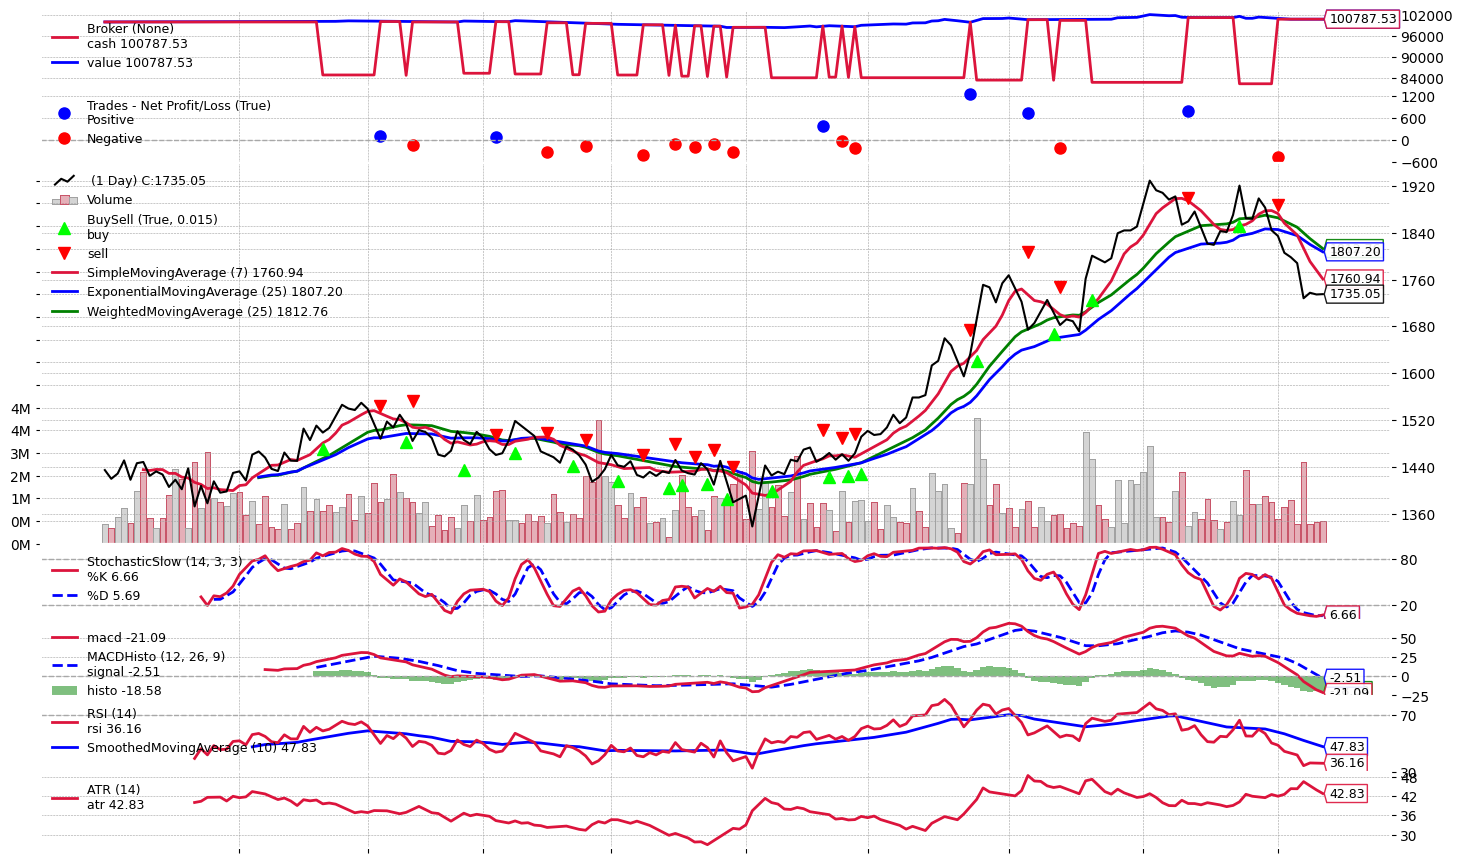

[[<Figure size 1500x900 with 8 Axes>]]

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt


# Set the figure size
plt.rcParams["figure.figsize"] = [15, 9]

cerebro.plot(iplot=False) 